In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import ConcatDataset
import torchvision
from torchvision import transforms

from dataloading.ouster import OusterCrop, OusterNormalize, OusterDataset
from network import PilotNet
from trainer import Trainer

import wandb

%load_ext autoreload
%autoreload 2

# Config

In [2]:
# Set path to where you bag files are extracted
#root_path = Path("/home/romet/data/datasets/ut/nvidia-data")
root_path = Path("/media/romet/data2/datasets/rally-estonia/dataset")
model_name = "lidar-v3"

use_augmentation = False
wandb_logging = True

# Hyperparameters
n_epochs = 100
patience = 10
learning_rate = 1e-3
weight_decay = 0.01

## Datasets

In [3]:

train_paths = [
            root_path / "2021-05-20-12-36-10_e2e_sulaoja_20_30",
            root_path / "2021-05-20-12-43-17_e2e_sulaoja_20_30",
            root_path / "2021-05-20-12-51-29_e2e_sulaoja_20_30",
            root_path / "2021-05-20-13-44-06_e2e_sulaoja_10_10",
            root_path / "2021-05-20-13-51-21_e2e_sulaoja_10_10",
            root_path / "2021-05-20-13-59-00_e2e_sulaoja_10_10",
            root_path / "2021-05-28-15-07-56_e2e_sulaoja_20_30",
            root_path / "2021-05-28-15-17-19_e2e_sulaoja_20_30",
            root_path / "2021-06-09-13-14-51_e2e_rec_ss2",
            root_path / "2021-06-09-13-55-03_e2e_rec_ss2_backwards",
            root_path / "2021-06-09-14-58-11_e2e_rec_ss3",
            root_path / "2021-06-09-15-42-05_e2e_rec_ss3_backwards",
            root_path / "2021-06-09-16-24-59_e2e_rec_ss13",
            root_path / "2021-06-09-16-50-22_e2e_rec_ss13_backwards",
            root_path / "2021-06-10-12-59-59_e2e_ss4",
            root_path / "2021-06-10-13-19-22_e2e_ss4_backwards",
            root_path / "2021-06-10-13-51-34_e2e_ss12",
            root_path / "2021-06-10-14-02-24_e2e_ss12_backwards",
            root_path / "2021-06-10-14-44-24_e2e_ss3_backwards",
            root_path / "2021-06-10-15-03-16_e2e_ss3_backwards",
            root_path / "2021-06-14-11-08-19_e2e_rec_ss14",
            root_path / "2021-06-14-11-22-05_e2e_rec_ss14",
            root_path / "2021-06-14-11-22-05_e2e_rec_ss14",
            root_path / "2021-06-14-11-43-48_e2e_rec_ss14_backwards",
            root_path / "2021-09-24-11-19-25_e2e_rec_ss10",
            root_path / "2021-09-24-11-40-24_e2e_rec_ss10_2",
            root_path / "2021-09-24-12-02-32_e2e_rec_ss10_3",
            root_path / "2021-09-24-12-21-20_e2e_rec_ss10_backwards",
            root_path / "2021-09-24-13-39-38_e2e_rec_ss11",
            root_path / "2021-09-30-13-57-00_e2e_rec_ss14",
            root_path / "2021-09-30-15-03-37_e2e_ss14_from_half_way",
            root_path / "2021-09-30-15-20-14_e2e_ss14_backwards",
            root_path / "2021-09-30-15-56-59_e2e_ss14_attempt_2",
            root_path / "2021-10-07-11-05-13_e2e_rec_ss3",
            root_path / "2021-10-07-11-44-52_e2e_rec_ss3_backwards",
            root_path / "2021-10-07-12-54-17_e2e_rec_ss4",
            root_path / "2021-10-07-13-22-35_e2e_rec_ss4_backwards",
            root_path / "2021-10-11-16-06-44_e2e_rec_ss2",
            root_path / "2021-10-11-17-10-23_e2e_rec_last_part",
            root_path / "2021-10-11-17-14-40_e2e_rec_backwards",
            root_path / "2021-10-11-17-20-12_e2e_rec_backwards",
            root_path / "2021-10-20-14-55-47_e2e_rec_vastse_ss13_17",
            root_path / "2021-10-20-13-57-51_e2e_rec_neeruti_ss19_22",
            root_path / "2021-10-20-14-15-07_e2e_rec_neeruti_ss19_22_back",
            root_path / "2021-10-25-17-31-48_e2e_rec_ss2_arula",
            root_path / "2021-10-25-17-06-34_e2e_rec_ss2_arula_back"
]

tr = transforms.Compose([OusterCrop(), OusterNormalize()])
#tr = transforms.Compose([OusterNormalize()])
trainset = OusterDataset(train_paths, transform=tr)
# trainset.frames["turn_signal"] = trainset.frames["turn_signal"].astype(int)
# trainset.frames = trainset.frames[trainset.frames.turn_signal==1]
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True,
                                         num_workers=32, pin_memory=True, persistent_workers=True)
print(len(trainset.frames))

/media/romet/data2/datasets/rally-estonia/dataset/2021-05-20-12-36-10_e2e_sulaoja_20_30: 8013
/media/romet/data2/datasets/rally-estonia/dataset/2021-05-20-12-43-17_e2e_sulaoja_20_30: 4537
/media/romet/data2/datasets/rally-estonia/dataset/2021-05-20-12-51-29_e2e_sulaoja_20_30: 3590
/media/romet/data2/datasets/rally-estonia/dataset/2021-05-20-13-44-06_e2e_sulaoja_10_10: 3831
/media/romet/data2/datasets/rally-estonia/dataset/2021-05-20-13-51-21_e2e_sulaoja_10_10: 3796
/media/romet/data2/datasets/rally-estonia/dataset/2021-05-20-13-59-00_e2e_sulaoja_10_10: 686
/media/romet/data2/datasets/rally-estonia/dataset/2021-05-28-15-07-56_e2e_sulaoja_20_30: 10418
/media/romet/data2/datasets/rally-estonia/dataset/2021-05-28-15-17-19_e2e_sulaoja_20_30: 2147
/media/romet/data2/datasets/rally-estonia/dataset/2021-06-09-13-14-51_e2e_rec_ss2: 33279
/media/romet/data2/datasets/rally-estonia/dataset/2021-06-09-13-55-03_e2e_rec_ss2_backwards: 35827
/media/romet/data2/datasets/rally-estonia/dataset/2021-06-09

torch.Size([3, 68, 264])


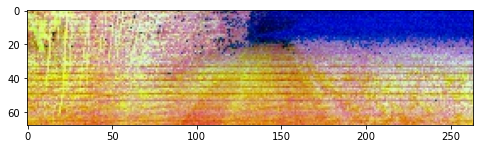

In [4]:
lidar_image = trainset[300]["image"]
print(lidar_image.shape)
plt.figure(figsize=(8, 8))
plt.imshow(lidar_image.permute(1, 2, 0))

In [5]:
valid_paths = [
            root_path / "2021-05-28-15-19-48_e2e_sulaoja_20_30",
            root_path / "2021-06-07-14-20-07_e2e_rec_ss6",
            root_path / "2021-06-07-14-06-31_e2e_rec_ss6",
            root_path / "2021-06-07-14-09-18_e2e_rec_ss6",
            root_path / "2021-06-07-14-36-16_e2e_rec_ss6",
            root_path / "2021-09-24-14-03-45_e2e_rec_ss11_backwards",
            root_path / "2021-10-26-10-49-06_e2e_rec_ss20_elva",
            root_path / "2021-10-26-11-08-59_e2e_rec_ss20_elva_back",
            root_path / "2021-10-20-15-11-29_e2e_rec_vastse_ss13_17_back",
            root_path / "2021-10-11-14-50-59_e2e_rec_vahi",
            root_path / "2021-10-14-13-08-51_e2e_rec_vahi_backwards"
              ]
validset = OusterDataset(valid_paths, transform=tr)

# validset.frames["turn_signal"] = validset.frames["turn_signal"].astype(int)
# validset.frames = validset.frames[validset.frames.turn_signal==1]

validloader = torch.utils.data.DataLoader(validset, batch_size=64, shuffle=False,
                                         num_workers=32, pin_memory=True, persistent_workers=True)
print(len(validset.frames))

/media/romet/data2/datasets/rally-estonia/dataset/2021-05-28-15-19-48_e2e_sulaoja_20_30: 7138
/media/romet/data2/datasets/rally-estonia/dataset/2021-06-07-14-20-07_e2e_rec_ss6: 17224
/media/romet/data2/datasets/rally-estonia/dataset/2021-06-07-14-06-31_e2e_rec_ss6: 2001
/media/romet/data2/datasets/rally-estonia/dataset/2021-06-07-14-09-18_e2e_rec_ss6: 3032
/media/romet/data2/datasets/rally-estonia/dataset/2021-06-07-14-36-16_e2e_rec_ss6: 16912
/media/romet/data2/datasets/rally-estonia/dataset/2021-09-24-14-03-45_e2e_rec_ss11_backwards: 8391
/media/romet/data2/datasets/rally-estonia/dataset/2021-10-26-10-49-06_e2e_rec_ss20_elva: 11016
/media/romet/data2/datasets/rally-estonia/dataset/2021-10-26-11-08-59_e2e_rec_ss20_elva_back: 11094
/media/romet/data2/datasets/rally-estonia/dataset/2021-10-20-15-11-29_e2e_rec_vastse_ss13_17_back: 8921
/media/romet/data2/datasets/rally-estonia/dataset/2021-10-11-14-50-59_e2e_rec_vahi: 7071
/media/romet/data2/datasets/rally-estonia/dataset/2021-10-14-13-0

## Train model

In [6]:
model = PilotNet()
criterion = nn.L1Loss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), 
                              eps=1e-08, weight_decay=weight_decay, amsgrad=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = criterion.to(device)

trainer = Trainer(model_name, wandb_logging=wandb_logging)
trainer.train(model, trainloader, validloader, optimizer, criterion, n_epochs)

wandb: Currently logged in as: rometaidla (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.6 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


  0%|          | 0/9768 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

Saving best model.


  0%|          | 0/9768 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

Saving best model.


  0%|          | 0/9768 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

Saving best model.


  0%|          | 0/9768 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

Saving best model.


  0%|          | 0/9768 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/9768 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/9768 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/9768 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/9768 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/9768 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

Saving best model.


  0%|          | 0/9768 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/9768 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

Saving best model.


  0%|          | 0/9768 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/9768 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/9768 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

Saving best model.


  0%|          | 0/9768 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/9768 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/9768 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/9768 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/9768 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/9768 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/9768 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/9768 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/9768 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/9768 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

Early stopping, on epoch: 25.


  0%|          | 0/1520 [00:00<?, ?it/s]

{'mae': 8.024522371082567, 'rmse': 28.942584249874418, 'max': 798.3108758345727, 'whiteness': 299.04715, 'expert_whiteness': 59.24675021026411}


0.140053166996222